In [2]:
!pip install segmentation-models-pytorch --quiet

     |████████████████████████████████| 97 kB 3.2 MB/s 
     |████████████████████████████████| 376 kB 54.5 MB/s 
     |████████████████████████████████| 58 kB 4.3 MB/s 


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils as smp_utils

In [4]:
RANDOM_STATE = 42
GDRIVE = True

In [5]:
data_root = None
if GDRIVE:
    data_root = "/content/drive/MyDrive/GoogleColabProjects/FewShotKneeJointSpaceSegmentation/data/"

In [6]:
class JointSpaceSegmentationDataset(Dataset):
    def __init__(self, img_root, mask_root, image_files, mask_files, transforms=None, preprocessing=None):
        self.img_root = img_root
        self.mask_root = mask_root
        self.img_files = image_files
        self.mask_files = mask_files
        self.transforms = transforms
        self.preprocessing = preprocessing

    def __len__(self):
        return len(self.img_files)
    
    def __getitem__(self, idx):
        image = np.array(Image.open(os.path.join(self.img_root, self.img_files[idx])))
        mask = np.array(Image.open(os.path.join(self.mask_root, self.mask_files[idx])))

        # image = np.stack([image, image, image], axis=0)
        # mask = np.expand_dims(mask, axis=0)
        if self.transforms is not None:
            transformed = self.transforms(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        mask = torch.unsqueeze(mask, 0)
        if self.preprocessing is not None:
            transformed = self.preprocessing(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
            
        return image.type(torch.FloatTensor), mask/255.0

In [7]:
from sklearn.model_selection import train_test_split
def generate_datasets(root_dir):
    x_dir = os.path.join(root_dir, "Train_X")
    y_dir = os.path.join(root_dir, "Train_Y")
    records = [[img.split(".")[0][:-1], img, img] for img in os.listdir(x_dir)]
 
    data_records = pd.DataFrame(records, columns=["pid", "images", "masks"])
    
    train, test = train_test_split(data_records.pid.unique(), test_size=0.5, random_state=42)
    valid, test = train_test_split(test, test_size=0.5, random_state=42)
    
    train = data_records[data_records.pid.isin(train)].reset_index(drop=True)
    valid = data_records[data_records.pid.isin(valid)].reset_index(drop=True)
    test = data_records[data_records.pid.isin(test)].reset_index(drop=True)

    return train, valid, test
    

In [8]:
def get_few_shot_sample(dataset, k=1, random_state=42):
    if k > len(dataset):
        return dataset
    
    return dataset.sample(k, random_state=random_state).reset_index(drop=True)

In [9]:
train, valid, test = generate_datasets(os.path.join(data_root, "images"))

In [10]:
train

,pid,images,masks
0,9993261,9993261L.png,9993261L.png
1,9997610,9997610L.png,9997610L.png
2,9989700,9989700L.png,9989700L.png
3,9976720,9976720L.png,9976720L.png
4,9980800,9980800L.png,9980800L.png
5,9995338,9995338R.png,9995338R.png
6,9985803,9985803L.png,9985803L.png
7,9975778,9975778R.png,9975778R.png
8,9981316,9981316R.png,9981316R.png
9,9980752,9980752L.png,9980752L.png


In [11]:
len(test)

23

In [12]:
train_few = get_few_shot_sample(train, k=5)
valid_few = get_few_shot_sample(valid, k=5)
test_few = get_few_shot_sample(test, k=5)

In [14]:
valid_few

,pid,images,masks
0,9988820,9988820L.png,9988820L.png
1,9978026,9978026L.png,9978026L.png
2,9980704,9980704L.png,9980704L.png
3,9994408,9994408R.png,9994408R.png
4,9983246,9983246R.png,9983246R.png


In [ ]:
def get_preprocessing_fn(encoder, encoder_weights):
    return smp.encoders.get_preprocessing_fn(encoder, encoder_weights)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
        ToTensorV2(),
    ]
    return A.Compose(_transform)

In [ ]:
encoder = "resnet34"
encoder_weights = "imagenet"
activation = None
num_classes = 1 # 0=background, 1=joint space

preprocessing_fn = get_preprocessing_fn(encoder, encoder_weights)

In [ ]:
augmentations = A.Compose([A.Resize(256, 256), ToTensorV2()]) # A.OneOf([A.Emboss(), Canny()

In [ ]:
from pandas._libs.lib import tuples_to_object_array
train_set = JointSpaceSegmentationDataset(os.path.join(data_root, "images/Train_X"),
                                          os.path.join(data_root, "images/Train_Y"),
                                          train_few.images, train_few.masks, 
                                          preprocessing=None,#get_preprocessing(preprocessing_fn), 
                                          transforms=augmentations)

valid_set = JointSpaceSegmentationDataset(os.path.join(data_root, "images/Train_X"),
                                          os.path.join(data_root, "images/Train_Y"),
                                          valid_few.images, valid_few.masks,     
                                          preprocessing=None,#get_preprocessing(preprocessing_fn),
                                          transforms=augmentations)

test_set = JointSpaceSegmentationDataset(os.path.join(data_root, "images/Train_X"),
                                         os.path.join(data_root, "images/Train_Y"),
                                         test_few.images, test_few.masks, 
                                         preprocessing=None,#get_preprocessing(preprocessing_fn),
                                         transforms=augmentations)

In [ ]:
import copy
model = copy.deepcopy(smp.Unet(encoder_name=encoder, encoder_weights=encoder_weights, in_channels=1,
                 classes=num_classes, activation=activation)).cuda()
model.encoder.requires_grad_ = True
loss = smp.losses.JaccardLoss(mode="binary")
loss.__name__="loss"
metrics = [smp_utils.metrics.IoU(threshold=0.5), smp_utils.metrics.Fscore(0.5)]
optimizer = torch.optim.Adam(model.parameters(), lr=5e-04)

In [ ]:
train_loader = DataLoader(train_set, batch_size=2, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_set, batch_size=2, shuffle=False, num_workers=2)

In [ ]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device="cuda",
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device="cuda",
    verbose=True,
)

In [ ]:
# train model for 40 epochs

max_score = 0

for i in range(1, 50):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i % 750 == 0:
        optimizer.param_groups[0]['lr'] /= 10
        print('Decrease decoder learning rate!')


Epoch: 1
valid: 100%|██████████| 5/5 [00:01<00:00,  4.57it/s, loss - 0.9372, iou_score - 0.1208, fscore - 0.2234]
Model saved!

Epoch: 2
valid: 100%|██████████| 5/5 [00:00<00:00, 15.85it/s, loss - 0.8818, iou_score - 0.3209, fscore - 0.394]
Model saved!

Epoch: 3
valid: 100%|██████████| 5/5 [00:00<00:00, 15.66it/s, loss - 0.8616, iou_score - 0.3972, fscore - 0.4732]
Model saved!

Epoch: 4
valid: 100%|██████████| 5/5 [00:00<00:00, 11.64it/s, loss - 0.8467, iou_score - 0.5052, fscore - 0.6151]
Model saved!

Epoch: 5
valid: 100%|██████████| 5/5 [00:00<00:00, 10.59it/s, loss - 0.8067, iou_score - 0.6341, fscore - 0.7172]
Model saved!

Epoch: 6
valid: 100%|██████████| 5/5 [00:00<00:00, 15.82it/s, loss - 0.793, iou_score - 0.6426, fscore - 0.7365]
Model saved!

Epoch: 7
valid: 100%|██████████| 5/5 [00:00<00:00, 15.68it/s, loss - 0.7189, iou_score - 0.6822, fscore - 0.7524]
Model saved!

Epoch: 8
valid: 100%|██████████| 5/5 [00:00<00:00, 10.29it/s, loss - 0.6958, iou_score - 0.7345, fscore -

In [ ]:
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=2)
test_img, test_mask  = next(iter(test_loader))

In [ ]:
import matplotlib.pyplot as plt
model = torch.load("best_model.pth").cuda()
model.eval()

# fig, ax = plt.subplots(10, 3, figsize=(10, 10), sharex=True, sharey=True)
# fig.suptitle("Few-Shot Segmentation Results (K = 10)")
# for i, (img, mask) in enumerate(test_loader):
#     ax[i, 0].imshow(img[0][0,:,:].squeeze(),cmap="gray")
#     ax[i, 0].set_title("X-Ray")
#     ax[i, 1].imshow(mask.squeeze())
#     ax[i, 1].set_title("Mask")
#     ax[i, 2].imshow(torch.sigmoid(model(img.cuda()).squeeze().detach().cpu()).numpy())
#     ax[i, 2].set_title("Predicted Mask")

# fig.savefig(data_root + "1-shot_seg_results.jpg")

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
avg_iou = 0.0
avg_fscore = 0.0
iou_metric = smp.utils.metrics.IoU(threshold=0.5)
fscore_metric = smp.utils.metrics.Fscore(threshold=0.5)
for img, mask in test_loader:
    out = model(img.cuda())
    mask = mask.cuda()
    avg_iou += iou_metric(out, mask).item()
    avg_fscore += fscore_metric(out, mask).item()

print(avg_iou/len(test_loader), avg_fscore/len(test_loader))

0.8546290814876556 0.9208752691745759


In [ ]:
torch.save(model, data_root + "unet_10shot_noaug.pth")

In [ ]:
import imgaug as ia

In [ ]:
aug = ia.augmenters.Canny(alpha=(0.25, 1))

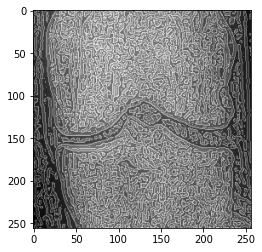

In [ ]:
plt.imshow(aug.augment_image(img.numpy().squeeze().astype(np.uint8)), cmap="gray")

In [ ]:
from albumentations.core.transforms_interface import ImageOnlyTransform

class Canny(ImageOnlyTransform):
    def apply(self, img, **params):
        aug = ia.augmenters.Canny(alpha=(0.25, 0.75))
        return aug.augment_images(img.astype(np.uint8))

In [ ]:
can = Canny()


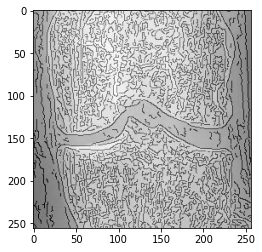

In [ ]:
plt.imshow(can(image=img.numpy().squeeze())["image"], cmap="gray")